# Coleta dos dados históricos, exploração dos dados, pré-processamento e previsões com os modelos escolhidos:

## Importando e instalando as Dependências necessárias

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install scikit-learn
!pip install tensorflow matplotlib
!pip install statsmodels
!pip install arch

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mpf
from numpy.polynomial import Polynomial
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model

2024-09-14 17:27:38.188691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 17:27:38.189267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 17:27:38.191591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 17:27:38.198638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 17:27:38.210612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Coleta dos dados históricos: ETH-USD

In [3]:
# Definindo o símbolo da cripto (ETH-USD)
symbol = 'ETH-USD'

# Coletando os dados históricos em um range de 2020-2024
eth_data = yf.download(symbol, start="2020-01-01", end="2024-09-14", interval="1d")

# Visualizando os primeiros registros
eth_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330
2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256
2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358
2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515
2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353


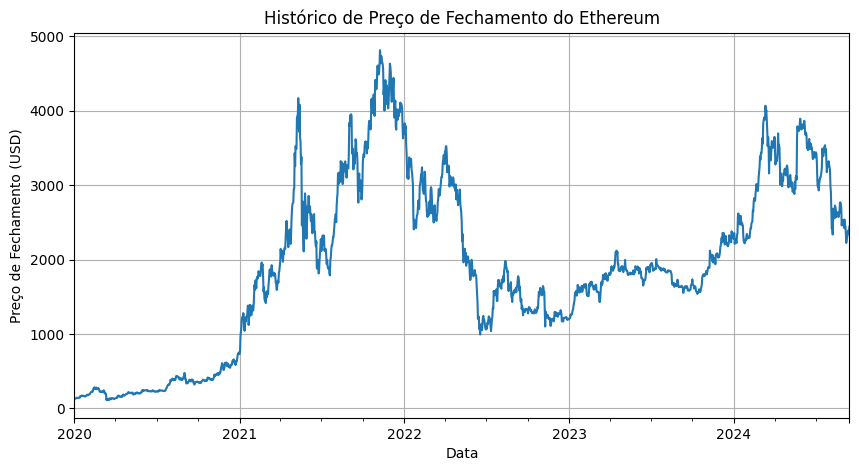

In [4]:
# Plotar os dados de fechamento (Close)
eth_data['Close'].plot(figsize=(10,5))
plt.title('Histórico de Preço de Fechamento do Ethereum')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid()
plt.show()

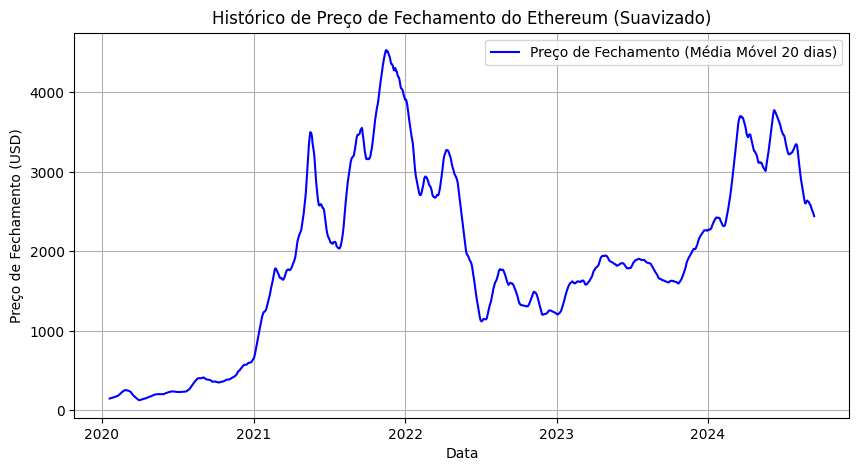

In [5]:
# Aplicando uma média móvel de 20 dias para suavizar o gráfico de fechamento
eth_data['Close_Smooth'] = eth_data['Close'].rolling(window=20).mean()

# Plotando os dados de fechamento suavizados
plt.figure(figsize=(10, 5))
plt.plot(eth_data['Close_Smooth'], label='Preço de Fechamento (Média Móvel 20 dias)', color='blue')
plt.title('Histórico de Preço de Fechamento do Ethereum (Suavizado)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
eth_data.to_csv('eth_historical_data.csv')

## Análise exploratória: ETH-USD

In [7]:
# Examinando o formato dos dados coletados
eth_data.info()

# Exibindo as primeiras linhas dos dados
eth_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1718 entries, 2020-01-01 to 2024-09-13
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1718 non-null   float64
 1   High          1718 non-null   float64
 2   Low           1718 non-null   float64
 3   Close         1718 non-null   float64
 4   Adj Close     1718 non-null   float64
 5   Volume        1718 non-null   int64  
 6   Close_Smooth  1699 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 107.4 KB


,Open,High,Low,Close,Adj Close,Volume,Close_Smooth
Date,,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330,NaN
2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256,NaN
2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358,NaN
2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515,NaN
2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353,NaN


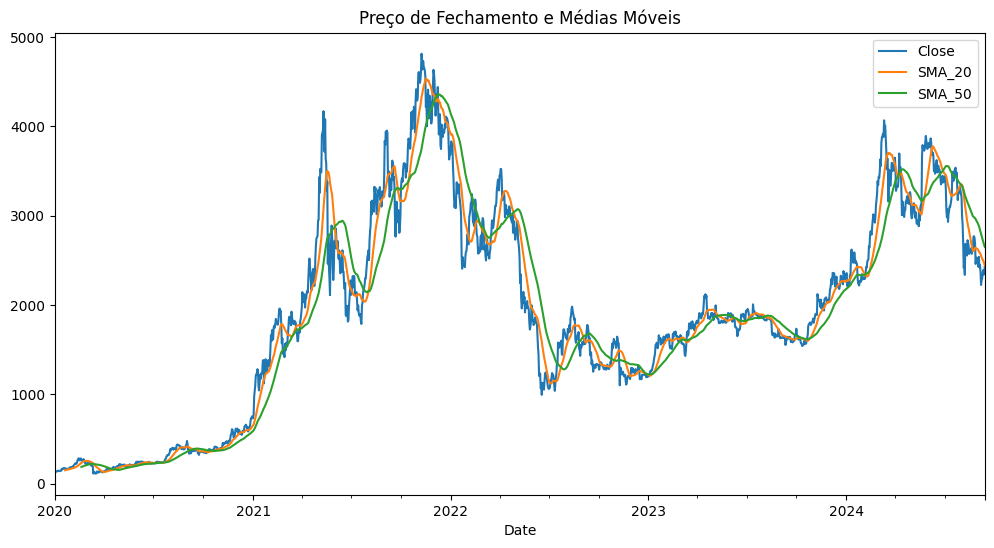

In [8]:
# Calculando médias móveis simples (SMA) de 20 e 50 dias
eth_data['SMA_20'] = eth_data['Close'].rolling(window=20).mean()
eth_data['SMA_50'] = eth_data['Close'].rolling(window=50).mean()

# Visualizando as médias móveis junto com o preço de fechamento sem suavizar
eth_data[['Close', 'SMA_20', 'SMA_50']].plot(figsize=(12, 6))
plt.title('Preço de Fechamento e Médias Móveis')
plt.show()

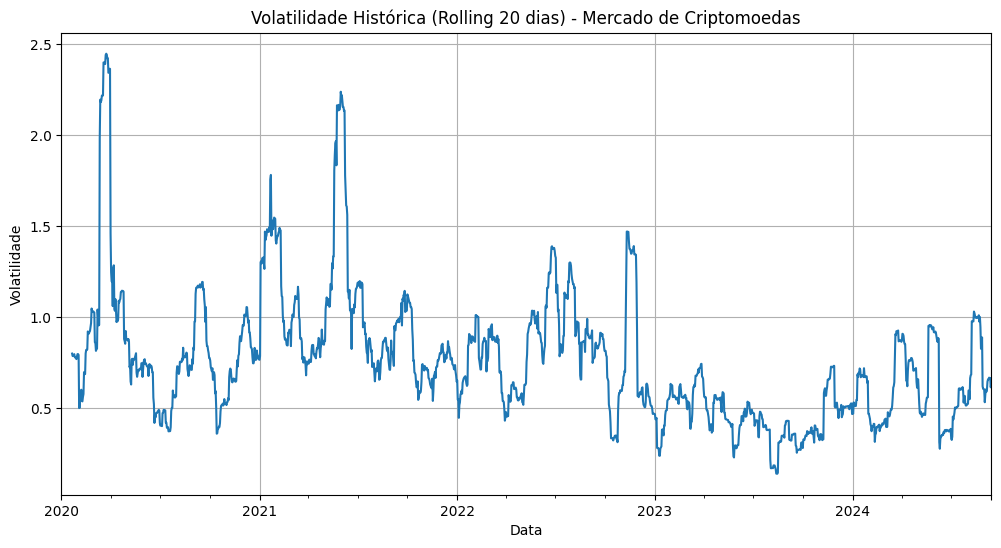

In [9]:
# Calculando a volatilidade diária (mudança percentual)
eth_data['Daily_Return'] = eth_data['Close'].pct_change()

# Calculando a volatilidade (desvio padrão da mudança percentual) com 365 dias, refletindo o mercado contínuo
eth_data['Volatility'] = eth_data['Daily_Return'].rolling(window=20).std() * np.sqrt(365)

# Plotando a volatilidade ajustada
eth_data['Volatility'].plot(figsize=(12,6))
plt.title('Volatilidade Histórica (Rolling 20 dias) - Mercado de Criptomoedas')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.grid(True)
plt.show()

In [10]:
# Calculando a correlação entre 'Close' (preço de fechamento) e 'Volume'
correlation = eth_data[['Close', 'Volume']].corr()

# Exibindo a correlação
print(correlation)

           Close    Volume
Close   1.000000  0.215429
Volume  0.215429  1.000000


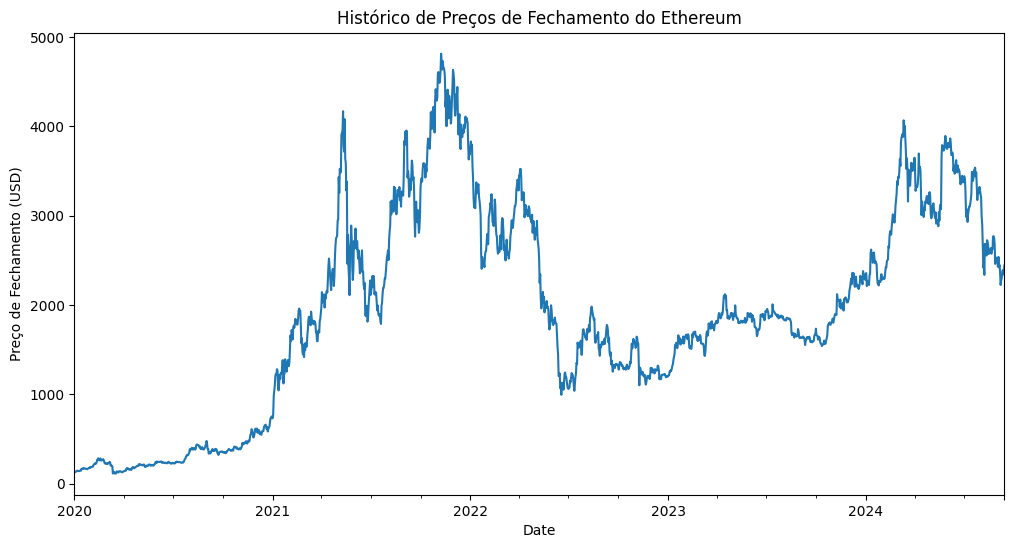

In [11]:
# Plotando o preço de fechamento para observar os padrões
eth_data['Close'].plot(figsize=(12, 6))
plt.title('Histórico de Preços de Fechamento do Ethereum')
plt.ylabel('Preço de Fechamento (USD)')
plt.show()

/home/rizzi26/Documents/GitHub/faculdade/Atividade-Ponderada-M7/src/venv/lib64/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


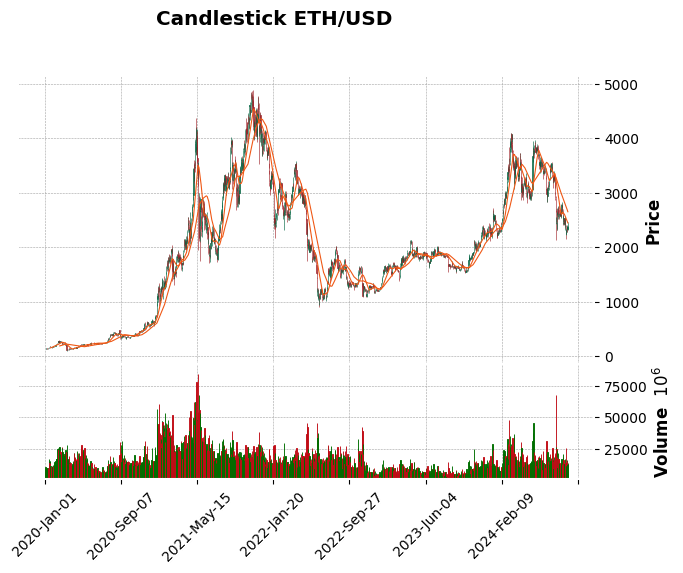

In [12]:
# Criando um gráfico de candlestick para o ETH
mpf.plot(eth_data, type='candle', style='charles', volume=True, mav=(20, 50), title="Candlestick ETH/USD")

### Analisando tendências 

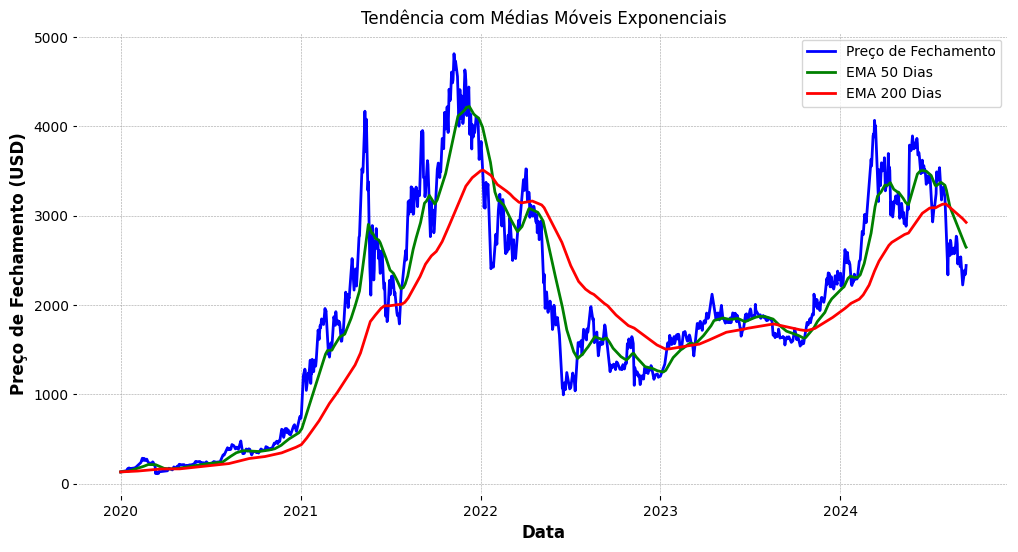

In [13]:
# Calculando Média Móvel Exponencial (EMA)
eth_data['EMA50'] = eth_data['Close'].ewm(span=50, adjust=False).mean()
eth_data['EMA200'] = eth_data['Close'].ewm(span=200, adjust=False).mean()

# Plotando o gráfico com médias móveis
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.plot(eth_data['EMA50'], label='EMA 50 Dias', color='green')
plt.plot(eth_data['EMA200'], label='EMA 200 Dias', color='red')
plt.title('Tendência com Médias Móveis Exponenciais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from numpy.polynomial import Polynomial

# Ajuste polinomial de grau 3, por exemplo
coefs = Polynomial.fit(X['Date_Ordinal'], y, 3)
eth_data['Polynomial_Trend'] = coefs(X['Date_Ordinal'])

plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.plot(eth_data['Polynomial_Trend'], label='Tendência Polinomial', color='orange')
plt.title('Tendência Polinomial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X' is not defined

### Analisando de anomalias

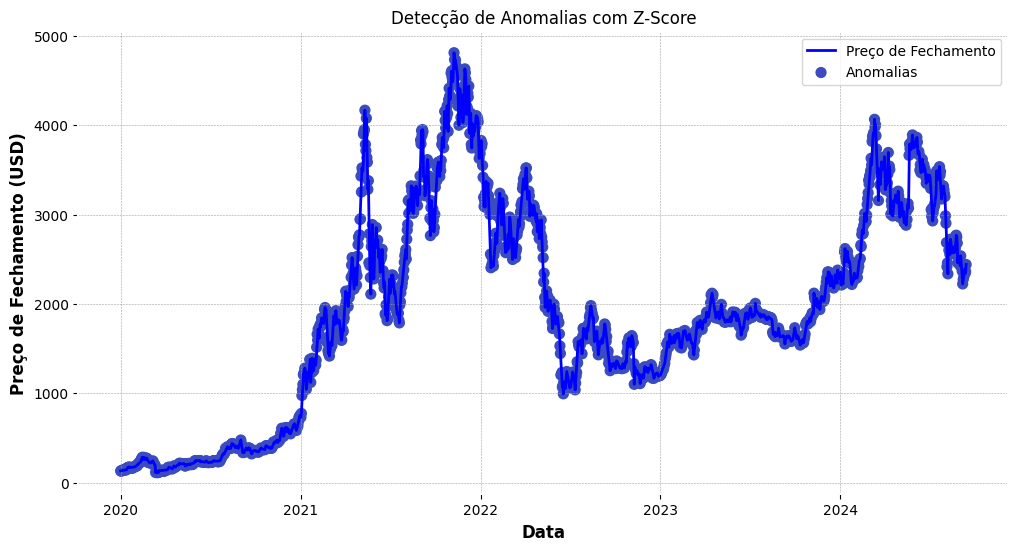

In [15]:
# Calcular o Z-Score para os preços de fechamento
eth_data['Z-Score'] = stats.zscore(eth_data['Close'].dropna())

# Definir um limite para considerar uma anomalia
anomaly_threshold = 3

# Identificar anomalias
eth_data['Anomaly'] = eth_data['Z-Score'].apply(lambda x: x if abs(x) > anomaly_threshold else 0)

# Plotar os dados e marcar as anomalias
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.scatter(eth_data.index, eth_data['Close'], c=eth_data['Anomaly'], cmap='coolwarm', label='Anomalias', s=50)
plt.title('Detecção de Anomalias com Z-Score')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

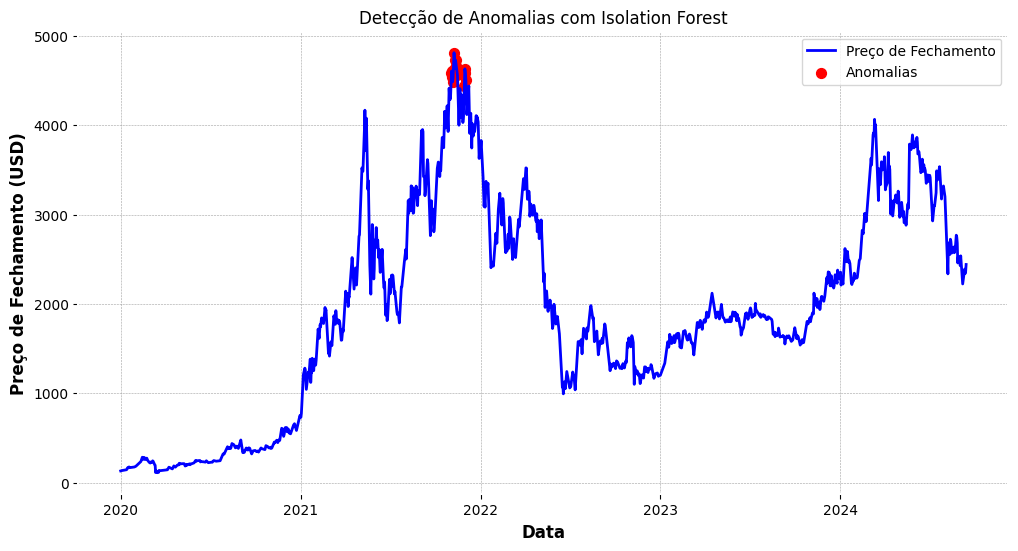

In [16]:
# Ajustar o Isolation Forest
isolation_forest = IsolationForest(contamination=0.01)
eth_data['Anomaly_IF'] = isolation_forest.fit_predict(eth_data[['Close']].dropna())

# Identificar anomalias (-1 indica anomalia)
anomalies = eth_data[eth_data['Anomaly_IF'] == -1]

# Plotar as anomalias
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalias', s=50)
plt.title('Detecção de Anomalias com Isolation Forest')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

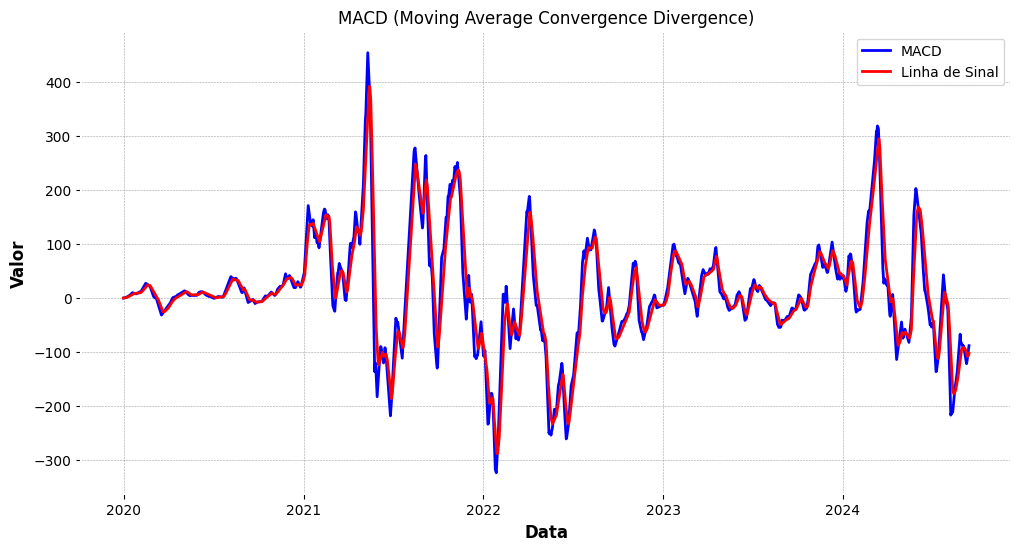

In [17]:
# MACD
eth_data['EMA12'] = eth_data['Close'].ewm(span=12, adjust=False).mean()
eth_data['EMA26'] = eth_data['Close'].ewm(span=26, adjust=False).mean()
eth_data['MACD'] = eth_data['EMA12'] - eth_data['EMA26']
eth_data['Signal_Line'] = eth_data['MACD'].ewm(span=9, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(eth_data['MACD'], label='MACD', color='blue')
plt.plot(eth_data['Signal_Line'], label='Linha de Sinal', color='red')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Pré-Processamento

In [18]:
# Preencher valores faltantes
eth_data.dropna(inplace=True)

In [19]:
# Normalização dos dados entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
eth_data_scaled = scaler.fit_transform(eth_data[['Close']])  # Usando apenas o preço de fechamen

In [20]:
# Dividir os dados entre treino e teste
train_size = int(len(eth_data_scaled) * 0.8)
train_scaled, test_scaled = eth_data_scaled[:train_size], eth_data_scaled[train_size:]

In [21]:
# Função para criar sequências
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [22]:
def prepare_arima_data(data, train_size):
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

# Preparar dados para ARIMA
eth_series = pd.Series(eth_data['Close'])
train_data_arima, test_data_arima = prepare_arima_data(eth_series, train_size)

In [23]:
def prepare_garch_data(data, train_size):
    returns = data.pct_change().dropna()
    train_data = returns[:train_size]
    test_data = returns[train_size:]
    return train_data, test_data

# Preparar dados para GARCH
train_returns, test_returns = prepare_garch_data(eth_series, train_size)

## Treinamento e avaliação dos modelos escolhidos:

### LSTM

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ajustar formato dos dados para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir e treinar o modelo LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Fazer previsões
predictions_lstm = model_lstm.predict(X_test)

Epoch 1/10


/home/rizzi26/Documents/GitHub/faculdade/Atividade-Ponderada-M7/src/venv/lib64/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0629 - val_loss: 0.0033
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0017
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [25]:
# Dividir dados em treino e teste
train_size = int(len(data) * 0.8)
train_data_arima, test_data_arima = data[:train_size], data[train_size:]

# Ajustar o modelo ARIMA
model_arima = ARIMA(train_data_arima, order=(5,1,0))
model_arima_fit = model_arima.fit()

# Fazer previsões
predictions_arima = model_arima_fit.forecast(steps=len(test_data_arima))

# Avaliação das previsões
error_arima = mean_squared_error(test_data_arima, predictions_arima)
print(f'Erro ARIMA: {error_arima}')

plt.figure(figsize=(12, 6))
plt.plot(data, label='Dados Reais')
plt.plot(range(len(train_data_arima), len(data)), predictions_arima, label='Previsões ARIMA', color='orange')
plt.title('Previsões ARIMA')
plt.xlabel('Observações')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'data' is not defined

In [ ]:
from arch import arch_model
import numpy as np
from sklearn.metrics import mean_squared_error

# Escalonamento dos dados
scale_factor = 1000
train_returns_scaled = train_returns * scale_factor
test_returns_scaled = test_returns * scale_factor

# Ajustar o modelo GARCH
model_garch = arch_model(train_returns_scaled, vol='Garch', p=1, q=1)
model_garch_fit = model_garch.fit(rescale=False)  # Desative o reescalonamento interno

# Fazer previsões
forecast_length = len(test_returns)
predictions_garch = model_garch_fit.forecast(start=0, horizon=forecast_length)

# Verifique se predictions_garch contém previsões para todo o horizonte
if forecast_length <= len(predictions_garch.variance):
    predicted_variance = predictions_garch.variance.values[-forecast_length:]
    predicted_std = np.sqrt(predicted_variance) / scale_factor  # Desescalonamento
    
    # Verificar os formatos das previsões e dos dados de teste
    print(f"Tamanho de test_returns: {len(test_returns)}")
    print(f"Tamanho de predicted_std: {len(predicted_std)}")
    
    # Avaliar previsões
    if len(test_returns) == len(predicted_std):
        error_garch = mean_squared_error(test_returns, predicted_std)
        print(f'Erro GARCH: {error_garch}')
    else:
        print("Os comprimentos dos dados de teste e das previsões não coincidem.")
else:
    print("O horizonte de previsão solicitado é maior do que a quantidade de previsões disponíveis.")

In [28]:
import yfinance as yf

# Carregar dados do Ethereum (ETH) como exemplo
eth_data = yf.download('ETH-USD', start='2020-01-01', end='2023-12-31')

# Agora, o DataFrame conterá a coluna 'Date' como índice
eth_data['Date'] = eth_data.index

# Convertendo a coluna 'Date' para ordinal
eth_data['Date_Ordinal'] = pd.to_datetime(eth_data['Date']).map(pd.Timestamp.toordinal)

[*********************100%***********************]  1 of 1 completed


Polinômio de grau 1:
 - MSE: 1042856.82
 - MAE: 842.18
 - R²: 0.15

Polinômio de grau 3:
 - MSE: 559898.40
 - MAE: 590.46
 - R²: 0.54

Polinômio de grau 5:
 - MSE: 255592.49
 - MAE: 404.76
 - R²: 0.79

Polinômio de grau 7:
 - MSE: 153118.45
 - MAE: 278.81
 - R²: 0.88

Polinômio de grau 9:
 - MSE: 123275.71
 - MAE: 222.95
 - R²: 0.90

Polinômio de grau 11:
 - MSE: 118203.05
 - MAE: 219.01
 - R²: 0.90

Polinômio de grau 13:
 - MSE: 116725.25
 - MAE: 226.14
 - R²: 0.90



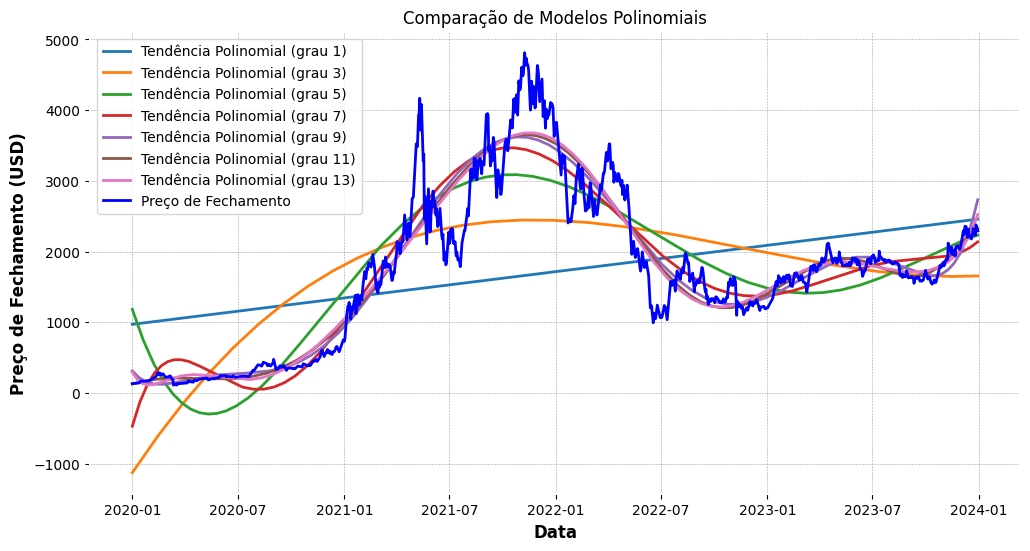

In [30]:
# Definindo X e y
X = eth_data[['Date_Ordinal']]
y = eth_data['Close']

# Função para ajustar o polinômio e calcular métricas
def ajustar_polinomio_e_avaliar(grau):
    coefs = Polynomial.fit(X['Date_Ordinal'], y, grau)
    predicao = coefs(X['Date_Ordinal'])
    
    mse = mean_squared_error(y, predicao)
    mae = mean_absolute_error(y, predicao)
    r2 = r2_score(y, predicao)
    
    print(f"Polinômio de grau {grau}:")
    print(f" - MSE: {mse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - R²: {r2:.2f}\n")
    
    return predicao

# Ajuste e avaliação de polinômios de diferentes graus
graus = [1, 3, 5, 7,]
tendencias = {}

plt.figure(figsize=(12, 6))

for grau in graus:
    tendencia = ajustar_polinomio_e_avaliar(grau)
    tendencias[grau] = tendencia
    plt.plot(eth_data['Date'], tendencia, label=f'Tendência Polinomial (grau {grau})')

# Plotar os dados reais
plt.plot(eth_data['Date'], eth_data['Close'], label='Preço de Fechamento', color='blue', linewidth=2)

plt.title('Comparação de Modelos Polinomiais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supondo que 'eth_data' já está carregado e tem as colunas 'Date' e 'Close'

# Garantindo que a coluna 'Date' está no formato ordinal
eth_data['Date_Ordinal'] = pd.to_datetime(eth_data['Date']).map(pd.Timestamp.toordinal)

# Definindo X e y
X = eth_data[['Date_Ordinal']]
y = eth_data['Close']

# Função para ajustar o polinômio e calcular métricas
def ajustar_polinomio_e_avaliar(grau):
    coefs = Polynomial.fit(X['Date_Ordinal'], y, grau)
    predicao = coefs(X['Date_Ordinal'])
    
    mse = mean_squared_error(y, predicao)
    mae = mean_absolute_error(y, predicao)
    r2 = r2_score(y, predicao)
    
    print(f"Polinômio de grau {grau}:")
    print(f" - MSE: {mse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - R²: {r2:.2f}\n")
    
    return predicao

# Ajuste e avaliação de polinômios de diferentes graus
graus = [1, 3, 5, 7]
tendencias = {}

plt.figure(figsize=(12, 6))

for grau in graus:
    tendencia = ajustar_polinomio_e_avaliar(grau)
    tendencias[grau] = tendencia
    plt.plot(eth_data['Date'], tendencia, label=f'Tendência Polinomial (grau {grau})')

# Plotar os dados reais
plt.plot(eth_data['Date'], eth_data['Close'], label='Preço de Fechamento', color='blue', linewidth=2)

plt.title('Comparação de Modelos Polinomiais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Date'